# Stock Price Prediction with LSTM - Part 1

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Set plotting style
sns.set(style="whitegrid")

## 1. Data Loading and Exploratory Data Analysis (EDA)

First 5 rows of the dataset:
            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-17           0   2.296798  3.291227  3.344743  3.291227  0.000000   
1980-03-18           1   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-19           2   2.306134  3.304606  3.304606  3.304606  3.304606   
1980-03-20           3   2.306134  3.304606  3.358122  3.304606  0.000000   
1980-03-21           4   2.362154  3.384880  3.438396  3.384880  0.000000   

             Volume  
Date                 
1980-03-17  41109.0  
1980-03-18   9343.0  
1980-03-19      0.0  
1980-03-20  10277.0  
1980-03-21   8409.0  

Summary Statistics:
         Unnamed: 0     Adj Close         Close          High           Low  \
count  11291.000000  11198.000000  11174.000000  11196.000000  11164.000000   
mean    5645.000000     63.609130     72.026945     72.503100     71.665079   
std     3259.575279

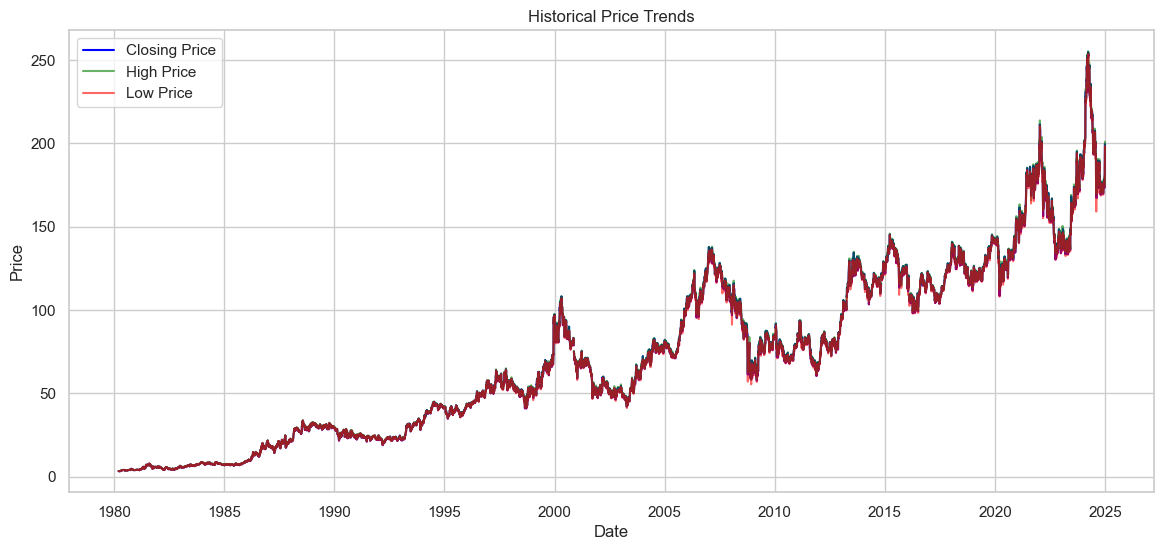

In [ ]:
# Load the data
df = pd.read_csv('../data/trading_summary.csv', parse_dates=['Date'], index_col='Date')

# Display basic info
print("First 5 rows of the dataset:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

# Plot historical price trends
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Closing Price', color='blue')
plt.plot(df['High'], label='High Price', alpha=0.6, color='green')
plt.plot(df['Low'], label='Low Price', alpha=0.6, color='red')
plt.title('Historical Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# if len(df) > 60:
#     decomposition = seasonal_decompose(df['Close'], model='additive', period=30)
#     decomposition.plot()
#     plt.show()

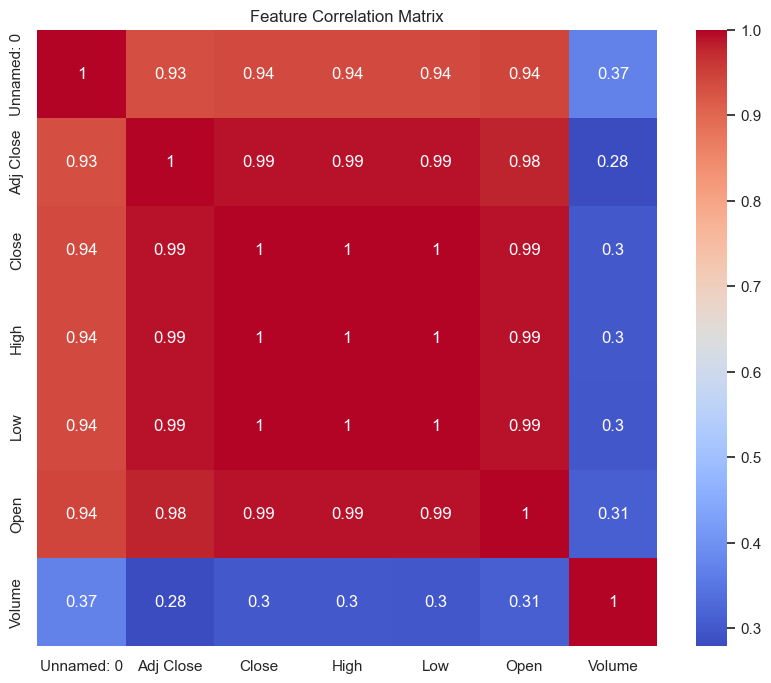

In [6]:
# Correlation analysis
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

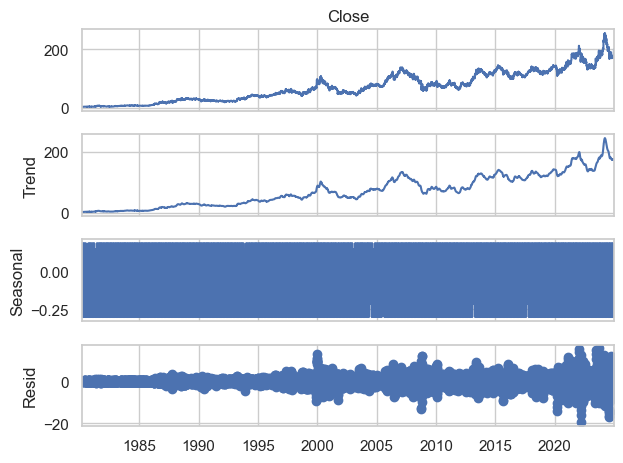

In [7]:
# Seasonal decomposition
result = seasonal_decompose(df['Close'].ffill(), period=30, model='additive')
result.plot()
plt.tight_layout()
plt.show()

## 2. Feature Engineering

In [15]:
# Create moving averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()

# Create lag features
df['Lag_1'] = df['Close'].shift(1)
df['Lag_2'] = df['Close'].shift(2)

# Calculate daily returns and volatility
df['Return'] = df['Close'].pct_change()
df['Volatility'] = df['Return'].rolling(window=5).std()

# Create target variable: closing price 5 trading days into the future
df['Target'] = df['Close'].shift(-5)

# Drop rows with NaN values generated by rolling and shifting operations
df.dropna(inplace=True)
print("\nData after feature engineering:")
print(df.head())


Data after feature engineering:
            Unnamed: 0  Adj Close     Close      High       Low      Open  \
Date                                                                        
1980-03-28           9   2.315470  3.317985  3.371501  3.317985  0.000000   
1980-04-01          11   2.278124  3.264469  3.317985  3.264469  0.000000   
1980-04-02          12   2.259452  3.237711  3.291227  3.237711  0.000000   
1980-04-03          13   2.259452  3.237711  3.237711  3.237711  3.237711   
1980-04-07          14   2.259452  3.237711  3.291227  3.237711  0.000000   

             Volume      MA_5     MA_10     Lag_1     Lag_2    Return  \
Date                                                                    
1980-03-28  36438.0  3.358122  3.338053  3.331364  3.371501 -0.004016   
1980-04-01   2803.0  3.320661  3.336716  3.317985  3.317985 -0.016129   
1980-04-02   6540.0  3.293903  3.330026  3.264469  3.317985 -0.008197   
1980-04-03      0.0  3.275172  3.323337  3.237711  3.264469  0

C:\Users\dasun\AppData\Local\Temp\ipykernel_24288\2652805041.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()


## 3. Data Preparation for LSTM

In [16]:
# Define features and target columns
feature_cols = ['Close', 'MA_5', 'MA_10', 'Lag_1', 'Lag_2', 'Volatility']
target_col = 'Target'

# Extract features and target
X = df[feature_cols].values
y = df[target_col].values

original_close = df['Close'].values

train_size = int(0.8 * len(X))

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X[:train_size])
X_scaled = np.concatenate([X_scaled, scaler_X.transform(X[train_size:])])

# Reshape y and scale
y = y.reshape(-1,1)
y_scaled = scaler_y.fit_transform(y[:train_size])
y_scaled = np.concatenate([y_scaled, scaler_y.transform(y[train_size:])])

sequence_length = 10

def create_sequences(X, y, original_close, seq_length):
    X_seq = []
    y_seq = []
    last_close_seq = []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i: i + seq_length])
        y_seq.append(y[i + seq_length - 1])
        last_close_seq.append(original_close[i + seq_length - 1])
    return np.array(X_seq), np.array(y_seq), np.array(last_close_seq)

X_seq, y_seq, last_close_seq = create_sequences(X_scaled, y_scaled, original_close, sequence_length)
print("Shape of sequences:", X_seq.shape, y_seq.shape)

# Split sequences into training and testing sets (80% train, 20% test)
train_samples = int(0.8 * len(X_seq))
X_train_seq = X_seq[:train_samples]
y_train_seq = y_seq[:train_samples]
last_close_train = last_close_seq[:train_samples]

X_test_seq = X_seq[train_samples:]
y_test_seq = y_seq[train_samples:]
last_close_test = last_close_seq[train_samples:]

print("Training sequences shape:", X_train_seq.shape)
print("Testing sequences shape:", X_test_seq.shape)

Shape of sequences: (9530, 10, 6) (9530, 1)
Training sequences shape: (7624, 10, 6)
Testing sequences shape: (1906, 10, 6)


## 4. LSTM Model Development and Training

In [18]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(sequence_length, len(feature_cols)), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_split=0.1, verbose=1)
model.save('../models/lstm_model.h5')

C:\Users\dasun\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0226 - val_loss: 0.0010
Epoch 2/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 3/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0012 - val_loss: 6.7646e-04
Epoch 5/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 6/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 9.3467e-04
Epoch 7/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6399e-04 - val_loss: 0.0012
Epoch 8/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8756e-04 - val_loss: 0.0019
Epoch 9/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7910e-04 - val_loss: 6.1062e-04
Epoch 10/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.0537e-04 - val_loss: 6.0156e-04
Epoch 11/100
215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.3233e-04 - val_loss: 6.5820e-04
E

## 5. Model Evaluation

In [20]:
# Make predictions on the test set
y_pred_scaled = model.predict(X_test_seq)

# Inverse transform predictions and actual target values to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
print("Test RMSE:", rmse)

pred_direction = np.sign(y_pred.flatten() - last_close_test)
actual_direction = np.sign(y_test_actual.flatten() - last_close_test)
directional_accuracy = np.mean(pred_direction == actual_direction)
print("Directional Accuracy:", directional_accuracy)

strategy_returns = np.where(pred_direction > 0,
                            (y_test_actual.flatten() - last_close_test) / last_close_test,
                            (last_close_test - y_test_actual.flatten()) / last_close_test)
cumulative_return = np.prod(1 + strategy_returns) - 1
print("Simulated Trading Cumulative Return:", cumulative_return)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test RMSE: 5.112731103255697
Directional Accuracy: 0.525183630640084
Simulated Trading Cumulative Return: 15.700877521671497


# 6. Save Predictions and Visualize Results

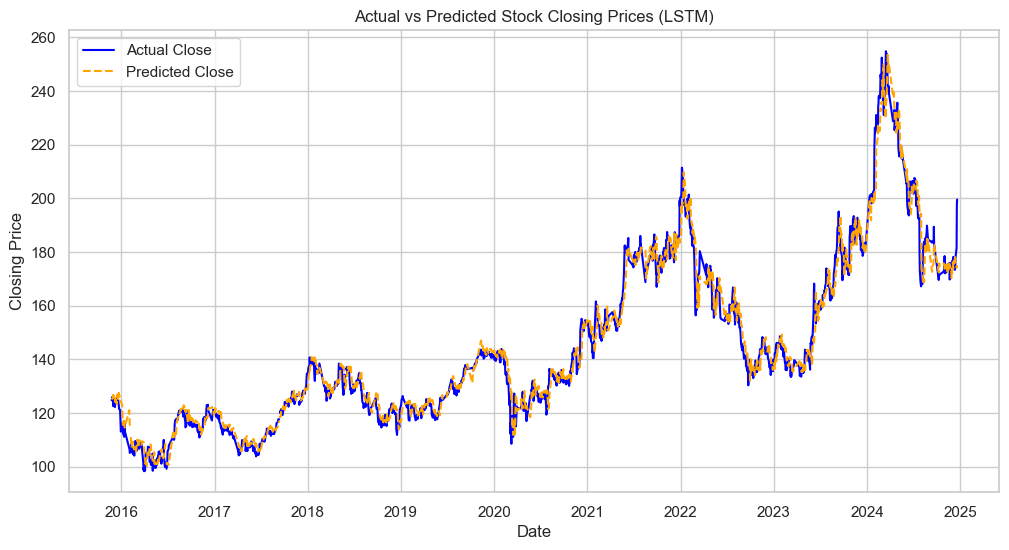

In [21]:
dates = df.index[train_samples + sequence_length - 1: train_samples + sequence_length - 1 + len(y_test_seq)]

predictions_df = pd.DataFrame({
    'Date': dates,
    'Actual_Close': y_test_actual.flatten(),
    'Predicted_Close': y_pred.flatten()
})
predictions_df.to_csv('../data/predictions_lstm.csv', index=False)

# Plot actual vs predicted closing prices
plt.figure(figsize=(12,6))
plt.plot(dates, y_test_actual.flatten(), label="Actual Close", color='blue')
plt.plot(dates, y_pred.flatten(), label="Predicted Close", color='orange', linestyle='--')
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Stock Closing Prices (LSTM)")
plt.legend()
plt.show()